In [1]:
import numpy as np
import matplotlib.pyplot as plt
import stim
from lib.stabilizer import measurement_gadgets, StabilizerCode, stabilizer_circuits
from lib.color_compass import *
from lib.decoder import checkmatrix,pL_from_checkmatrix
from lib.stim2pymatching import estimate_pL_noisy_graph
import stimcirq
from typing import *
from cirq.contrib.svg import SVGCircuit
import networkx as nx
import time
from tqdm import tqdm
import scipy.stats as ss
import pickle
from pymatching import Matching
from ldpc import bposd_decoder
from CompassCode import Lattice2D, choose_gauge_fixing, random_pauli, print_pauli_error, random_pauli_asym, pcheck_clipX, pcheck_clipZ

%load_ext autoreload
%autoreload 2

## Motivate 2D Compass Code Performance

### 2D Compass Codes vs Surface Code (Uniform Pauli Noise)

#### Minimum-Weight Perfect Matching

In [10]:
ds_lat = Lattice2D(4,4)
coloring = np.ones((9,))
# ds_lat.color_lattice(coloring)
lat = compass_to_surface(4,4)
for type in lat.stabs:
    for stab in type:
        print_pauli_error(stab, 4, 4)
        print('\n')

X | _ | _ | _
X | _ | _ | _
_ | _ | _ | _
_ | _ | _ | _


_ | X | X | _
_ | X | X | _
_ | _ | _ | _
_ | _ | _ | _


_ | _ | _ | X
_ | _ | _ | X
_ | _ | _ | _
_ | _ | _ | _


_ | _ | _ | _
X | X | _ | _
X | X | _ | _
_ | _ | _ | _


_ | _ | _ | _
_ | _ | X | X
_ | _ | X | X
_ | _ | _ | _


_ | _ | _ | _
_ | _ | _ | _
X | _ | _ | _
X | _ | _ | _


_ | _ | _ | _
_ | _ | _ | _
_ | X | X | _
_ | X | X | _


_ | _ | _ | _
_ | _ | _ | _
_ | _ | _ | X
_ | _ | _ | X


_ | Z | Z | _
_ | _ | _ | _
_ | _ | _ | _
_ | _ | _ | _


Z | Z | _ | _
Z | Z | _ | _
_ | _ | _ | _
_ | _ | _ | _


_ | _ | _ | _
_ | _ | _ | _
Z | Z | _ | _
Z | Z | _ | _


_ | _ | Z | Z
_ | _ | Z | Z
_ | _ | _ | _
_ | _ | _ | _


_ | _ | _ | _
_ | _ | _ | _
_ | _ | Z | Z
_ | _ | Z | Z


_ | _ | _ | _
_ | Z | Z | _
_ | Z | Z | _
_ | _ | _ | _


_ | _ | _ | _
_ | _ | _ | _
_ | _ | _ | _
_ | Z | Z | _




In [13]:
# Surface Code Simulation
dims = [3,5,7,9,11,15]
phys_err_rates_range = np.linspace(0.0001, 0.01, 10)
num_errors = 500 
bootstrapped_runs = 20
logical_errors = {dim: np.zeros((bootstrapped_runs, len(phys_err_rates_range),)) for dim in dims}

for dim in tqdm(dims):
    for bsr in range(bootstrapped_runs):
        lat = compass_to_surface(dim, dim)
        for i, phys_rate in enumerate(phys_err_rates_range):
            rates = [phys_rate, phys_rate, phys_rate]
            for err in range(num_errors):
                E = random_pauli(lat.size(), rates)
                while E == 'I' * lat.size():
                    E = random_pauli(lat.size(), rates)
                error = pauli2vector(E)
                pcheckX = lat.pcheckX() 
                pcheckZ = lat.pcheckZ() 
                pcheck = np.vstack((pcheckX, pcheckZ)) 
                syndromeZ = twisted_product(pcheckX, pauli2vector(E)) # Z-error syndrome 
                syndromeX = twisted_product(pcheckZ, pauli2vector(E)) # X-error syndrome 
                Hx = pcheck_clipX(pcheckX)
                Hz = pcheck_clipZ(pcheckZ)
                decodingX = Matching.from_check_matrix(Hx)
                decodingZ = Matching.from_check_matrix(Hz)
                recoveryX = decodingX.decode(syndromeZ)
                recoveryZ = decodingZ.decode(syndromeX)
                recovery = np.concatenate((recoveryZ, recoveryX))
                corrected_error = pauli2vector(E) + recovery % 2 

                if (twisted_product(pauli2vector(lat.Lx), corrected_error) == 1) or (twisted_product(pauli2vector(lat.Lz), corrected_error) == 1):
                    logical_errors[dim][bsr][i] += 1

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [22:24<00:00, 224.13s/it]


In [14]:
surface_code_logical_error_probs = {int(dim) : [] for dim in logical_errors.keys()}
for dim in logical_errors.keys():
    for row in logical_errors[dim]:
        surface_code_logical_error_probs[dim].append(row/num_errors)

with open('data/phys_vs_log_err_rate_surface_code_mwpm_1', 'wb') as fp:
    pickle.dump(surface_code_logical_error_probs, fp)

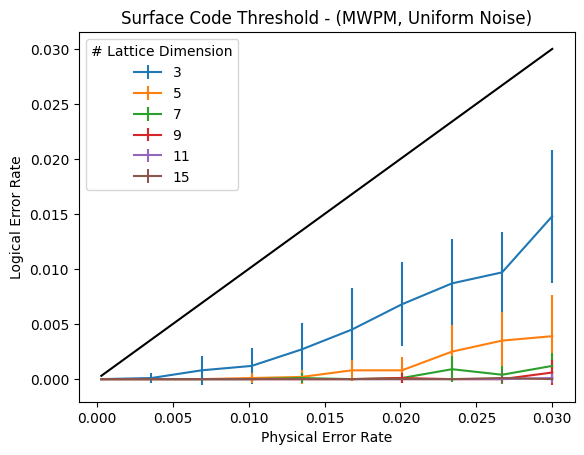

In [17]:
for dim in surface_code_logical_error_probs.keys():
    surface_code_logical_error_list = np.array(surface_code_logical_error_probs[dim])
    logical_error_list_mean = np.mean(surface_code_logical_error_list, axis=0)
    logical_error_list_std = np.std(surface_code_logical_error_list, axis=0)
    plt.errorbar(3 * phys_err_rates_range, logical_error_list_mean, yerr=logical_error_list_std, label=str(dim))

plt.xlabel('Physical Error Rate')
plt.ylabel('Logical Error Rate')
plt.title('Surface Code Threshold - (MWPM, Uniform Noise)')
plt.plot(3 * phys_err_rates_range, 3 * phys_err_rates_range, color='black')
plt.legend(title='# Lattice Dimension')

In [25]:
# Surface Code Simulation
dims = [3,5,7,9,11,15]
phys_err_rates_range = np.linspace(0.0001, 0.1, 10)
num_errors = 100 
bootstrapped_runs = 10
logical_errors = {dim: np.zeros((bootstrapped_runs, len(phys_err_rates_range),)) for dim in dims}

for dim in tqdm(dims):
    for bsr in range(bootstrapped_runs):
        lat = compass_to_surface(dim, dim)
        for i, phys_rate in enumerate(phys_err_rates_range):
            rates = [phys_rate, phys_rate, phys_rate]
            for err in range(num_errors):
                E = random_pauli(lat.size(), rates)
                while E == 'I' * lat.size():
                    E = random_pauli(lat.size(), rates)
                error = pauli2vector(E)
                pcheckX = lat.pcheckX() 
                pcheckZ = lat.pcheckZ() 
                pcheck = np.vstack((pcheckX, pcheckZ)) 
                syndromeZ = twisted_product(pcheckX, pauli2vector(E)) # Z-error syndrome 
                syndromeX = twisted_product(pcheckZ, pauli2vector(E)) # X-error syndrome 
                Hx = pcheck_clipX(pcheckX)
                Hz = pcheck_clipZ(pcheckZ)
                decodingX = Matching.from_check_matrix(Hx)
                decodingZ = Matching.from_check_matrix(Hz)
                recoveryX = decodingX.decode(syndromeZ)
                recoveryZ = decodingZ.decode(syndromeX)
                recovery = np.concatenate((recoveryZ, recoveryX))
                corrected_error = pauli2vector(E) + recovery % 2 

                if (twisted_product(pauli2vector(lat.Lx), corrected_error) == 1) or (twisted_product(pauli2vector(lat.Lz), corrected_error) == 1):
                    logical_errors[dim][bsr][i] += 1

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [02:33<00:00, 25.51s/it]


In [26]:
surface_code_logical_error_probs = {int(dim) : [] for dim in logical_errors.keys()}
for dim in logical_errors.keys():
    for row in logical_errors[dim]:
        surface_code_logical_error_probs[dim].append(row/num_errors)

with open('data/phys_vs_log_err_rate_long_surface_code_mwpm_1', 'wb') as fp:
    pickle.dump(surface_code_logical_error_probs, fp)

In [8]:
with open('data/phys_vs_log_err_rate_long_surface_code_mwpm_1', 'rb') as fp:
    surface_code_logical_error_probs = pickle.load(fp)

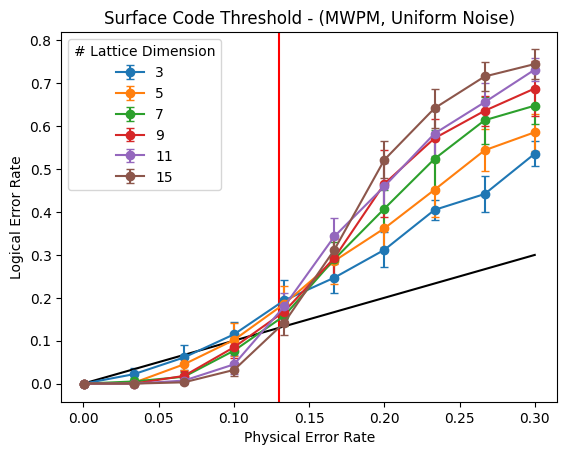

In [28]:
for dim in surface_code_logical_error_probs.keys():
    surface_code_logical_error_list = np.array(surface_code_logical_error_probs[dim])
    logical_error_list_mean = np.mean(surface_code_logical_error_list, axis=0)
    logical_error_list_std = np.std(surface_code_logical_error_list, axis=0)
    plt.errorbar(3 * phys_err_rates_range, logical_error_list_mean, yerr=logical_error_list_std, label=str(dim), fmt='o-', capsize=3)

plt.xlabel('Physical Error Rate')
plt.ylabel('Logical Error Rate')
plt.title('Surface Code Threshold - (MWPM, Uniform Noise)')
plt.axvline(0.13, color="red")
plt.plot(3 * phys_err_rates_range, 3 * phys_err_rates_range, color='black')
plt.legend(title='# Lattice Dimension')

In [16]:
# Compass Code Simulation
dims = [3,5,7,9,11,15]
phys_err_rates_range = np.linspace(0.0001, 0.01, 10)
num_errors = 500 
num_gauge_fixings = 20
logical_errors = {dim: np.zeros((num_gauge_fixings, len(phys_err_rates_range),)) for dim in dims}

for dim in tqdm(dims):
    for gf in range(num_gauge_fixings):
        lat = Lattice2D(dim, dim)
        coloring = np.zeros(((dim - 1)**2,))
        locs = np.random.choice(list(range((dim - 1)**2)), (dim - 1)**2, replace=False)
        for loc in locs:
            coloring[loc] = np.random.choice([-1,1])
        lat.color_lattice(coloring)
        for i, phys_rate in enumerate(phys_err_rates_range):
            rates = [phys_rate, phys_rate, phys_rate]
            for err in range(num_errors):
                E = random_pauli(lat.size(), rates)
                while E == 'I' * lat.size():
                    E = random_pauli(lat.size(), rates)
                error = pauli2vector(E)
                pcheckX = lat.pcheckX() 
                pcheckZ = lat.pcheckZ() 
                pcheck = np.vstack((pcheckX, pcheckZ)) 
                syndromeZ = twisted_product(pcheckX, pauli2vector(E)) # Z-error syndrome 
                syndromeX = twisted_product(pcheckZ, pauli2vector(E)) # X-error syndrome 
                Hx = pcheck_clipX(pcheckX)
                Hz = pcheck_clipZ(pcheckZ)
                decodingX = Matching.from_check_matrix(Hx)
                decodingZ = Matching.from_check_matrix(Hz)
                recoveryX = decodingX.decode(syndromeZ)
                recoveryZ = decodingZ.decode(syndromeX)
                recovery = np.concatenate((recoveryZ, recoveryX))
                corrected_error = pauli2vector(E) + recovery % 2 

                if (twisted_product(pauli2vector(lat.Lx), corrected_error) == 1) or (twisted_product(pauli2vector(lat.Lz), corrected_error) == 1):
                    logical_errors[dim][gf][i] += 1

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [04:15<04:15, 85.23s/it]


KeyboardInterrupt: 

In [19]:
compass_code_logical_error_probs = {int(dim) : [] for dim in logical_errors.keys()}
for dim in logical_errors.keys():
    for row in logical_errors[dim]:
        compass_code_logical_error_probs[dim].append(row/num_errors)

with open('data/phys_vs_log_err_rate_compass_code_mwpm_1', 'wb') as fp:
    pickle.dump(compass_code_logical_error_probs, fp)

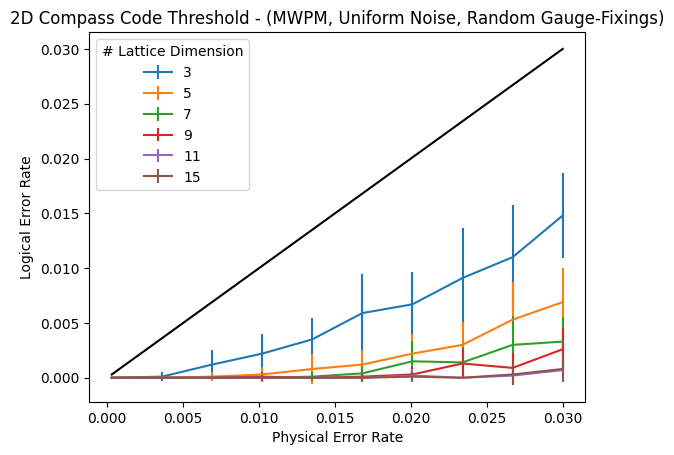

In [20]:
for dim in compass_code_logical_error_probs.keys():
    compass_code_logical_error_list = np.array(compass_code_logical_error_probs[dim])
    logical_error_list_mean = np.mean(compass_code_logical_error_list, axis=0)
    logical_error_list_std = np.std(compass_code_logical_error_list, axis=0)
    plt.errorbar(3 * phys_err_rates_range, logical_error_list_mean, yerr=logical_error_list_std, label=str(dim))

plt.xlabel('Physical Error Rate')
plt.ylabel('Logical Error Rate')
plt.title('2D Compass Code Threshold - (MWPM, Uniform Noise, Random Gauge-Fixings)')
plt.plot(3 * phys_err_rates_range, 3 * phys_err_rates_range, color='black')
plt.legend(title='# Lattice Dimension')

In [17]:
# Compass Code Simulation
dims = [3,5,7,9,11,15]
phys_err_rates_range = np.linspace(0.0001, 0.1, 10)
num_errors = 100 
num_gauge_fixings = 10
logical_errors = {dim: np.zeros((num_gauge_fixings, len(phys_err_rates_range),)) for dim in dims}

for dim in tqdm(dims):
    for gf in range(num_gauge_fixings):
        lat = Lattice2D(dim, dim)
        coloring = np.zeros(((dim - 1)**2,))
        locs = np.random.choice(list(range((dim - 1)**2)), (dim - 1)**2, replace=False)
        for loc in locs:
            coloring[loc] = np.random.choice([-1,1])
        lat.color_lattice(coloring)
        for i, phys_rate in enumerate(phys_err_rates_range):
            rates = [phys_rate, phys_rate, phys_rate]
            for err in range(num_errors):
                E = random_pauli(lat.size(), rates)
                while E == 'I' * lat.size():
                    E = random_pauli(lat.size(), rates)
                error = pauli2vector(E)
                pcheckX = lat.pcheckX() 
                pcheckZ = lat.pcheckZ() 
                pcheck = np.vstack((pcheckX, pcheckZ)) 
                syndromeZ = twisted_product(pcheckX, pauli2vector(E)) # Z-error syndrome 
                syndromeX = twisted_product(pcheckZ, pauli2vector(E)) # X-error syndrome 
                Hx = pcheck_clipX(pcheckX)
                Hz = pcheck_clipZ(pcheckZ)
                decodingX = Matching.from_check_matrix(Hx)
                decodingZ = Matching.from_check_matrix(Hz)
                recoveryX = decodingX.decode(syndromeZ)
                recoveryZ = decodingZ.decode(syndromeX)
                recovery = np.concatenate((recoveryZ, recoveryX))
                corrected_error = pauli2vector(E) + recovery % 2 

                if (twisted_product(pauli2vector(lat.Lx), corrected_error) == 1) or (twisted_product(pauli2vector(lat.Lz), corrected_error) == 1):
                    logical_errors[dim][gf][i] += 1

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [02:37<00:00, 26.33s/it]


In [18]:
compass_code_logical_error_probs = {int(dim) : [] for dim in logical_errors.keys()}
for dim in logical_errors.keys():
    for row in logical_errors[dim]:
        compass_code_logical_error_probs[dim].append(row/num_errors)

with open('data/phys_vs_log_err_rate_long_compass_code_mwpm_1', 'wb') as fp:
    pickle.dump(compass_code_logical_error_probs, fp)

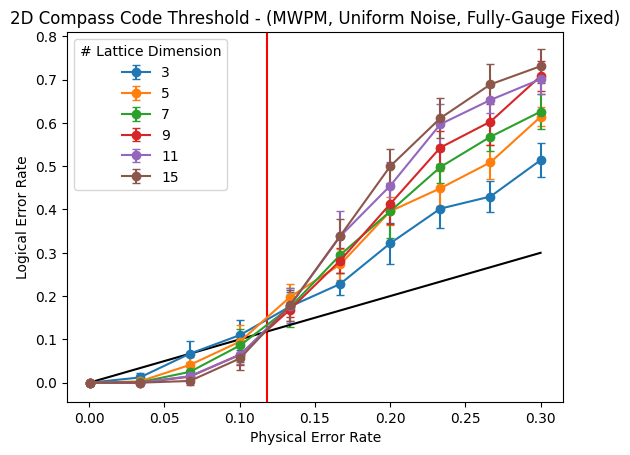

In [24]:
for dim in compass_code_logical_error_probs.keys():
    compass_code_logical_error_list = np.array(compass_code_logical_error_probs[dim])
    logical_error_list_mean = np.mean(compass_code_logical_error_list, axis=0)
    logical_error_list_std = np.std(compass_code_logical_error_list, axis=0)
    plt.errorbar(3 * phys_err_rates_range, logical_error_list_mean, yerr=logical_error_list_std, label=str(dim), capsize=3, fmt='o-')

plt.xlabel('Physical Error Rate')
plt.ylabel('Logical Error Rate')
plt.title('2D Compass Code Threshold - (MWPM, Uniform Noise, Fully-Gauge Fixed)')
plt.axvline(0.118, color="red")
plt.plot(3 * phys_err_rates_range, 3 * phys_err_rates_range, color='black')
plt.legend(title='# Lattice Dimension')

#### Belief Propagation + Ordered Statistics Decoding

In [12]:
# Surface Code Simulation
dims = [3,5,7,9,11,15]
phys_err_rates_range = np.linspace(0.0001, 0.01, 10)
num_errors = 100 
bootstrapped_runs = 10
logical_errors = {dim: np.zeros((bootstrapped_runs, len(phys_err_rates_range),)) for dim in dims}

for dim in tqdm(dims):
    for bsr in range(bootstrapped_runs):
        lat = compass_to_surface(dim, dim)
        num_qubits = lat.size()
        for i, phys_rate in enumerate(phys_err_rates_range):
            rates = [phys_rate, phys_rate, phys_rate]
            error_probability = np.sum(rates)
            for err in range(num_errors):
                E = random_pauli(lat.size(), rates)
                while E == 'I' * lat.size():
                    E = random_pauli(lat.size(), rates)
                error = pauli2vector(E)
                pcheckX = lat.pcheckX() 
                pcheckZ = lat.pcheckZ() 
                pcheck = np.vstack((pcheckX, pcheckZ)) 
                syndromeZ = twisted_product(pcheckX, pauli2vector(E)) # Z-error syndrome 
                syndromeX = twisted_product(pcheckZ, pauli2vector(E)) # X-error syndrome 
                Hx = pcheck_clipX(pcheckX)
                Hz = pcheck_clipZ(pcheckZ)
                bpd_X = bposd_decoder(
                    Hz,
                    error_rate = error_probability,
                    channel_probs = [None],
                    max_iter = num_qubits, 
                    bp_method = "ms",
                    ms_scaling_factor = 0,
                    osd_method = "osd_cs",
                    osd_order = 4
                )
                bpd_Z = bposd_decoder(
                    Hx,
                    error_rate = error_probability, 
                    channel_probs = [None], 
                    max_iter = num_qubits, 
                    bp_method = "ms", 
                    ms_scaling_factor=0, 
                    osd_method = "osd_cs", 
                    osd_order = 4
                )
                bpd_X.decode(syndromeX)
                bpd_Z.decode(syndromeZ)
                recovery = np.concatenate((bpd_X.osdw_decoding, bpd_Z.osdw_decoding))
                corrected_error = pauli2vector(E) + recovery % 2 

                if (twisted_product(pauli2vector(lat.Lx), corrected_error) == 1) or (twisted_product(pauli2vector(lat.Lz), corrected_error) == 1):
                    logical_errors[dim][bsr][i] += 1

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [02:53<00:00, 28.96s/it]


In [22]:
surface_code_logical_error_probs = {int(dim) : [] for dim in logical_errors.keys()}
for dim in logical_errors.keys():
    for row in logical_errors[dim]:
        surface_code_logical_error_probs[dim].append(row/num_errors)

with open('data/phys_vs_log_err_rate_surface_code_bposd_1', 'wb') as fp:
    pickle.dump(surface_code_logical_error_probs, fp)

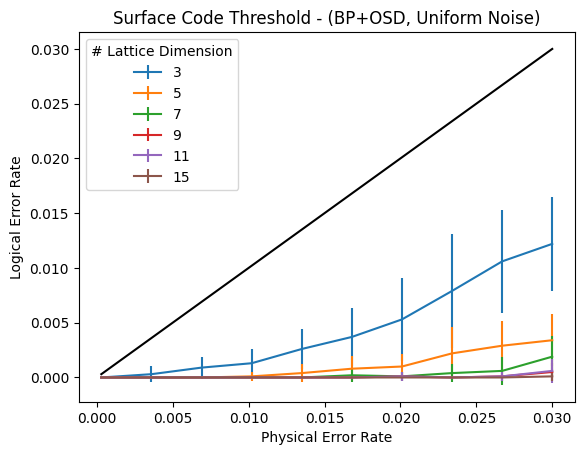

In [23]:
for dim in surface_code_logical_error_probs.keys():
    surface_code_logical_error_list = np.array(surface_code_logical_error_probs[dim])
    logical_error_list_mean = np.mean(surface_code_logical_error_list, axis=0)
    logical_error_list_std = np.std(surface_code_logical_error_list, axis=0)
    plt.errorbar(3 * phys_err_rates_range, logical_error_list_mean, yerr=logical_error_list_std, label=str(dim))

plt.xlabel('Physical Error Rate')
plt.ylabel('Logical Error Rate')
plt.title('Surface Code Threshold - (BP+OSD, Uniform Noise)')
plt.plot(3 * phys_err_rates_range, 3 * phys_err_rates_range, color='black')
plt.legend(title='# Lattice Dimension')

In [29]:
# Surface Code Simulation
dims = [3,5,7,9,11,15]
phys_err_rates_range = np.linspace(0.0001, 0.1, 10)
num_errors = 100 
bootstrapped_runs = 10
logical_errors = {dim: np.zeros((bootstrapped_runs, len(phys_err_rates_range),)) for dim in dims}

for dim in tqdm(dims):
    for bsr in range(bootstrapped_runs):
        lat = compass_to_surface(dim, dim)
        num_qubits = lat.size()
        for i, phys_rate in enumerate(phys_err_rates_range):
            rates = [phys_rate, phys_rate, phys_rate]
            error_probability = np.sum(rates)
            for err in range(num_errors):
                E = random_pauli(lat.size(), rates)
                while E == 'I' * lat.size():
                    E = random_pauli(lat.size(), rates)
                error = pauli2vector(E)
                pcheckX = lat.pcheckX() 
                pcheckZ = lat.pcheckZ() 
                pcheck = np.vstack((pcheckX, pcheckZ)) 
                syndromeZ = twisted_product(pcheckX, pauli2vector(E)) # Z-error syndrome 
                syndromeX = twisted_product(pcheckZ, pauli2vector(E)) # X-error syndrome 
                Hx = pcheck_clipX(pcheckX)
                Hz = pcheck_clipZ(pcheckZ)
                bpd_X = bposd_decoder(
                    Hz,
                    error_rate = error_probability,
                    channel_probs = [None],
                    max_iter = num_qubits, 
                    bp_method = "ms",
                    ms_scaling_factor = 0,
                    osd_method = "osd_cs",
                    osd_order = 4
                )
                bpd_Z = bposd_decoder(
                    Hx,
                    error_rate = error_probability, 
                    channel_probs = [None], 
                    max_iter = num_qubits, 
                    bp_method = "ms", 
                    ms_scaling_factor=0, 
                    osd_method = "osd_cs", 
                    osd_order = 4
                )
                bpd_X.decode(syndromeX)
                bpd_Z.decode(syndromeZ)
                recovery = np.concatenate((bpd_X.osdw_decoding, bpd_Z.osdw_decoding))
                corrected_error = pauli2vector(E) + recovery % 2 

                if (twisted_product(pauli2vector(lat.Lx), corrected_error) == 1) or (twisted_product(pauli2vector(lat.Lz), corrected_error) == 1):
                    logical_errors[dim][bsr][i] += 1

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [03:11<00:00, 31.96s/it]


In [30]:
surface_code_logical_error_probs = {int(dim) : [] for dim in logical_errors.keys()}
for dim in logical_errors.keys():
    for row in logical_errors[dim]:
        surface_code_logical_error_probs[dim].append(row/num_errors)

with open('data/phys_vs_log_err_rate_long_surface_code_bposd_1', 'wb') as fp:
    pickle.dump(surface_code_logical_error_probs, fp)

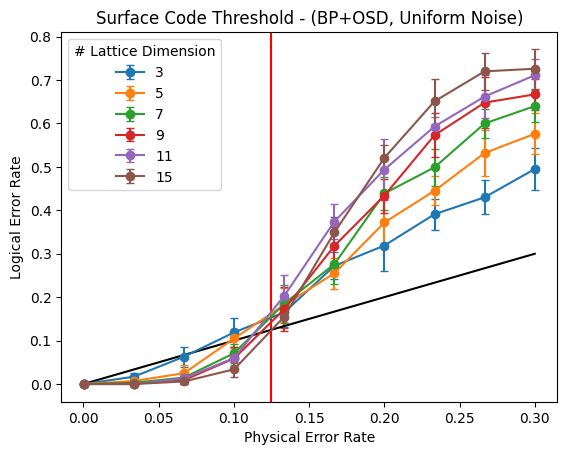

In [32]:
for dim in surface_code_logical_error_probs.keys():
    surface_code_logical_error_list = np.array(surface_code_logical_error_probs[dim])
    logical_error_list_mean = np.mean(surface_code_logical_error_list, axis=0)
    logical_error_list_std = np.std(surface_code_logical_error_list, axis=0)
    plt.errorbar(3 * phys_err_rates_range, logical_error_list_mean, yerr=logical_error_list_std, label=str(dim), fmt='o-', capsize=3)

plt.xlabel('Physical Error Rate')
plt.ylabel('Logical Error Rate')
plt.title('Surface Code Threshold - (BP+OSD, Uniform Noise)')
plt.axvline(0.125, color="red")
plt.plot(3 * phys_err_rates_range, 3 * phys_err_rates_range, color='black')
plt.legend(title='# Lattice Dimension')

In [50]:
# Compass Code Simulation
dims = [3,5,7,9,11,15]
phys_err_rates_range = np.linspace(0.0001, 0.01, 10)
num_errors = 500 
num_gauge_fixings = 20
logical_errors = {dim: np.zeros((num_gauge_fixings, len(phys_err_rates_range),)) for dim in dims}

for dim in tqdm(dims):
    for gf in range(num_gauge_fixings):
        lat = Lattice2D(dim, dim)
        coloring = np.random.randint(-1, 2, size=(dim - 1)**2)
        lat.color_lattice(coloring)
        for i, phys_rate in enumerate(phys_err_rates_range):
            rates = [phys_rate, phys_rate, phys_rate]
            for err in range(num_errors):
                E = random_pauli(lat.size(), rates)
                while E == 'I' * lat.size():
                    E = random_pauli(lat.size(), rates)
                error = pauli2vector(E)
                pcheckX = lat.pcheckX() 
                pcheckZ = lat.pcheckZ() 
                pcheck = np.vstack((pcheckX, pcheckZ)) 
                syndromeZ = twisted_product(pcheckX, pauli2vector(E)) # Z-error syndrome 
                syndromeX = twisted_product(pcheckZ, pauli2vector(E)) # X-error syndrome 
                Hx = pcheck_clipX(pcheckX)
                Hz = pcheck_clipZ(pcheckZ)
                bpd_X = bposd_decoder(
                    Hz,
                    error_rate = error_probability,
                    channel_probs = [None],
                    max_iter = num_qubits, 
                    bp_method = "ms",
                    ms_scaling_factor = 0,
                    osd_method = "osd_cs",
                    osd_order = 3 # Different from above!
                )
                bpd_Z = bposd_decoder(
                    Hx,
                    error_rate = error_probability, 
                    channel_probs = [None], 
                    max_iter = num_qubits, 
                    bp_method = "ms", 
                    ms_scaling_factor=0, 
                    osd_method = "osd_cs", 
                    osd_order = 3 # Different from above!
                )
                bpd_X.decode(syndromeX)
                bpd_Z.decode(syndromeZ)
                recovery = np.concatenate((bpd_X.osdw_decoding, bpd_Z.osdw_decoding))
                corrected_error = pauli2vector(E) + recovery % 2

                if (twisted_product(pauli2vector(lat.Lx), corrected_error) == 1) or (twisted_product(pauli2vector(lat.Lz), corrected_error) == 1):
                    logical_errors[dim][gf][i] += 1

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [20:18<00:00, 203.03s/it]


In [51]:
compass_code_logical_error_probs = {int(dim) : [] for dim in logical_errors.keys()}
for dim in logical_errors.keys():
    for row in logical_errors[dim]:
        compass_code_logical_error_probs[dim].append(row/num_errors)

with open('data/phys_vs_log_err_rate_compass_code_bposd_1', 'wb') as fp:
    pickle.dump(compass_code_logical_error_probs, fp)

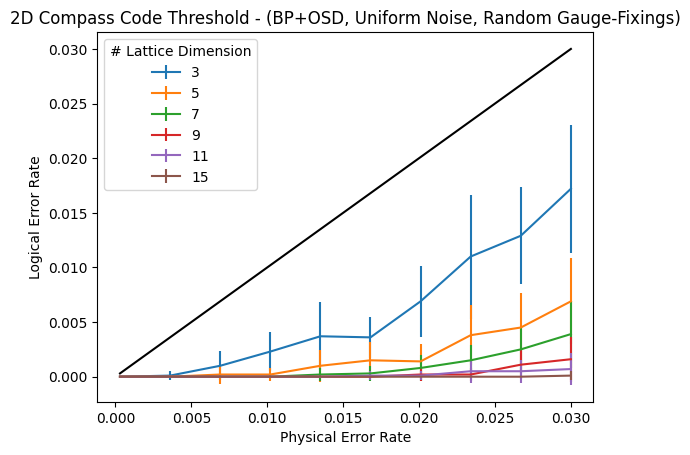

In [52]:
for dim in compass_code_logical_error_probs.keys():
    compass_code_logical_error_list = np.array(compass_code_logical_error_probs[dim])
    logical_error_list_mean = np.mean(compass_code_logical_error_list, axis=0)
    logical_error_list_std = np.std(compass_code_logical_error_list, axis=0)
    plt.errorbar(3 * phys_err_rates_range, logical_error_list_mean, yerr=logical_error_list_std, label=str(dim))

plt.xlabel('Physical Error Rate')
plt.ylabel('Logical Error Rate')
plt.title('2D Compass Code Threshold - (BP+OSD, Uniform Noise, Random Gauge-Fixings)')
plt.plot(3 * phys_err_rates_range, 3 * phys_err_rates_range, color='black')
plt.legend(title='# Lattice Dimension')

In [39]:
# Compass Code Simulation
dims = [3,5,7,9,11,15]
phys_err_rates_range = np.linspace(0.0001, 0.1, 10)
num_errors = 100 
num_gauge_fixings = 10
logical_errors = {dim: np.zeros((num_gauge_fixings, len(phys_err_rates_range),)) for dim in dims}

for dim in tqdm(dims):
    for gf in range(num_gauge_fixings):
        lat = Lattice2D(dim, dim)
        coloring = np.zeros(((dim - 1)**2,))
        locs = np.random.choice(list(range((dim - 1)**2)), (dim - 1)**2, replace=False)
        for loc in locs:
            coloring[loc] = np.random.choice([-1,1])
        lat.color_lattice(coloring)
        for i, phys_rate in enumerate(phys_err_rates_range):
            rates = [phys_rate, phys_rate, phys_rate]
            for err in range(num_errors):
                E = random_pauli(lat.size(), rates)
                while E == 'I' * lat.size():
                    E = random_pauli(lat.size(), rates)
                error = pauli2vector(E)
                pcheckX = lat.pcheckX() 
                pcheckZ = lat.pcheckZ() 
                pcheck = np.vstack((pcheckX, pcheckZ)) 
                syndromeZ = twisted_product(pcheckX, pauli2vector(E)) # Z-error syndrome 
                syndromeX = twisted_product(pcheckZ, pauli2vector(E)) # X-error syndrome 
                Hx = pcheck_clipX(pcheckX)
                Hz = pcheck_clipZ(pcheckZ)
                bpd_X = bposd_decoder(
                    Hz,
                    error_rate = error_probability,
                    channel_probs = [None],
                    max_iter = num_qubits, 
                    bp_method = "ms",
                    ms_scaling_factor = 0,
                    osd_method = "osd_cs",
                    osd_order = 3 # Different from above!
                )
                bpd_Z = bposd_decoder(
                    Hx,
                    error_rate = error_probability, 
                    channel_probs = [None], 
                    max_iter = num_qubits, 
                    bp_method = "ms", 
                    ms_scaling_factor=0, 
                    osd_method = "osd_cs", 
                    osd_order = 3 # Different from above!
                )
                bpd_X.decode(syndromeX)
                bpd_Z.decode(syndromeZ)
                recovery = np.concatenate((bpd_X.osdw_decoding, bpd_Z.osdw_decoding))
                corrected_error = pauli2vector(E) + recovery % 2

                if (twisted_product(pauli2vector(lat.Lx), corrected_error) == 1) or (twisted_product(pauli2vector(lat.Lz), corrected_error) == 1):
                    logical_errors[dim][gf][i] += 1

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [04:02<00:00, 40.39s/it]


In [40]:
compass_code_logical_error_probs = {int(dim) : [] for dim in logical_errors.keys()}
for dim in logical_errors.keys():
    for row in logical_errors[dim]:
        compass_code_logical_error_probs[dim].append(row/num_errors)

with open('data/phys_vs_log_err_rate_long_compass_code_bposd_1', 'wb') as fp:
    pickle.dump(compass_code_logical_error_probs, fp)

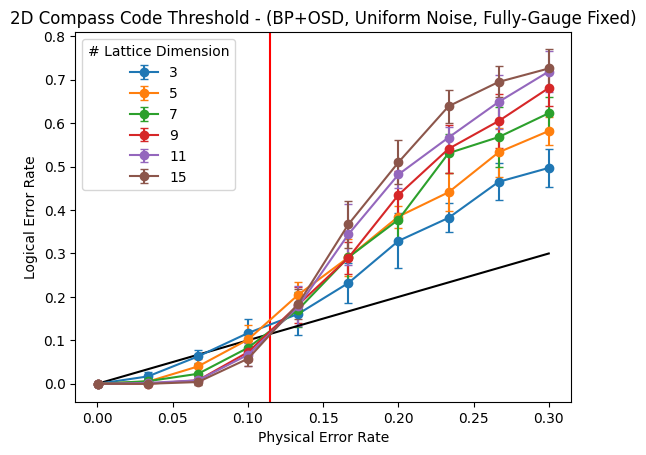

In [46]:
for dim in compass_code_logical_error_probs.keys():
    compass_code_logical_error_list = np.array(compass_code_logical_error_probs[dim])
    logical_error_list_mean = np.mean(compass_code_logical_error_list, axis=0)
    logical_error_list_std = np.std(compass_code_logical_error_list, axis=0)
    plt.errorbar(3 * phys_err_rates_range, logical_error_list_mean, yerr=logical_error_list_std, label=str(dim), fmt='o-', capsize=3)

plt.xlabel('Physical Error Rate')
plt.ylabel('Logical Error Rate')
plt.title('2D Compass Code Threshold - (BP+OSD, Uniform Noise, Fully-Gauge Fixed)')
plt.axvline(0.115, color='red')
plt.plot(3 * phys_err_rates_range, 3 * phys_err_rates_range, color='black')
plt.legend(title='# Lattice Dimension')

#### Union-Find

### 2D Compass Codes vs Surface Code (Biased & Symmetric Pauli Noise)

#### Minimum-Weight Perfect Matching

In [186]:
lat = Lattice2D(10, 10)
coloring = choose_gauge_fixing(10, 10, type='C', region=None)
lat.color_lattice(coloring)
print(lat)

000---001---002---003---004---005---006---007---008---009
 |  ▓  |  ░  |  ░  |  ░  |  ▓  |  ░  |  ░  |  ▓  |  ▓  |
010---011---012---013---014---015---016---017---018---019
 |  ░  |  ░  |  ▓  |  ░  |  ░  |  ▓  |  ▓  |  ▓  |  ▓  |
020---021---022---023---024---025---026---027---028---029
 |  ░  |  ░  |  ░  |  ▓  |  ░  |  ▓  |  ▓  |  ▓  |  ▓  |
030---031---032---033---034---035---036---037---038---039
 |  ▓  |  ░  |  ░  |  ░  |  ▓  |  ░  |  ░  |  ░  |  ░  |
040---041---042---043---044---045---046---047---048---049
 |  ▓  |  ░  |  ░  |  ▓  |  ░  |  ▓  |  ░  |  ▓  |  ░  |
050---051---052---053---054---055---056---057---058---059
 |  ▓  |  ░  |  ░  |  ░  |  ▓  |  ░  |  ░  |  ░  |  ░  |
060---061---062---063---064---065---066---067---068---069
 |  ░  |  ░  |  ░  |  ▓  |  ░  |  ░  |  ░  |  ▓  |  ▓  |
070---071---072---073---074---075---076---077---078---079
 |  ▓  |  ░  |  ░  |  ░  |  ▓  |  ░  |  ▓  |  ░  |  ▓  |
080---081---082---083---084---085---086---087---088---089
 |  ░  |  ░  |  ▓  |  

In [47]:
# Surface Code Simulation
# Biased towards Z errors

dims = [3,5,7,9,11,15]
phys_err_rates_range = np.linspace(0.0001, 0.13, 10)
num_errors = 100 
bootstrapped_runs = 10
logical_errors = {dim: np.zeros((bootstrapped_runs, len(phys_err_rates_range),)) for dim in dims}
all_rates = []

for dim in tqdm(dims):
    for bsr in range(bootstrapped_runs):
        lat = compass_to_surface(dim, dim)
        for i, phys_rate in enumerate(phys_err_rates_range):
            rates = [phys_rate, phys_rate * 0.1, phys_rate * 0.1]
            for err in range(num_errors):
                E = random_pauli(lat.size(), rates)
                while E == 'I' * lat.size():
                    E = random_pauli(lat.size(), rates)
                error = pauli2vector(E)
                pcheckX = lat.pcheckX() 
                pcheckZ = lat.pcheckZ() 
                pcheck = np.vstack((pcheckX, pcheckZ)) 
                syndromeZ = twisted_product(pcheckX, pauli2vector(E)) # Z-error syndrome 
                syndromeX = twisted_product(pcheckZ, pauli2vector(E)) # X-error syndrome 
                Hx = pcheck_clipX(pcheckX)
                Hz = pcheck_clipZ(pcheckZ)
                decodingX = Matching.from_check_matrix(Hx)
                decodingZ = Matching.from_check_matrix(Hz)
                recoveryX = decodingX.decode(syndromeZ)
                recoveryZ = decodingZ.decode(syndromeX)
                recovery = np.concatenate((recoveryZ, recoveryX))
                corrected_error = pauli2vector(E) + recovery % 2 

                if (twisted_product(pauli2vector(lat.Lx), corrected_error) == 1) or (twisted_product(pauli2vector(lat.Lz), corrected_error) == 1):
                    logical_errors[dim][bsr][i] += 1
total_phys_err_rates_range = [np.sum([r * 0.1, r * 0.1, r]) for r in phys_err_rates_range]

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [03:08<00:00, 31.42s/it]


In [48]:
surface_code_logical_error_probs = {int(dim) : [] for dim in logical_errors.keys()}
for dim in logical_errors.keys():
    for row in logical_errors[dim]:
        surface_code_logical_error_probs[dim].append(row/num_errors)

with open('data/phys_vs_log_err_rate_biased_surface_code_mwpm_1', 'wb') as fp:
    pickle.dump(surface_code_logical_error_probs, fp)

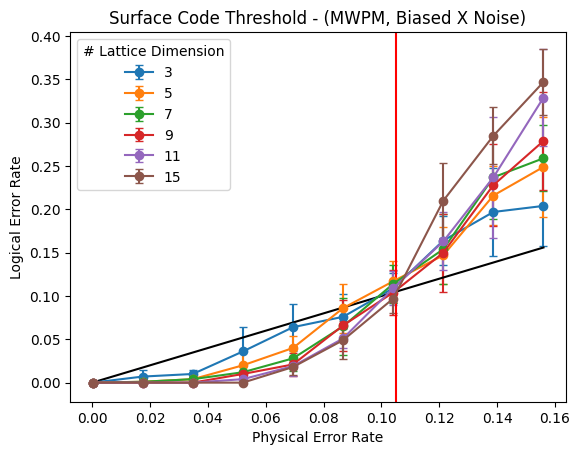

In [51]:
for dim in surface_code_logical_error_probs.keys():
    surface_code_logical_error_list = np.array(surface_code_logical_error_probs[dim])
    logical_error_list_mean = np.mean(surface_code_logical_error_list, axis=0)
    logical_error_list_std = np.std(surface_code_logical_error_list, axis=0)
    plt.errorbar(total_phys_err_rates_range, logical_error_list_mean, yerr=logical_error_list_std, label=str(dim), capsize=3, fmt='o-')

plt.xlabel('Physical Error Rate')
plt.ylabel('Logical Error Rate')
plt.title('Surface Code Threshold - (MWPM, Biased X Noise)')
plt.axvline(0.105, color='red')
plt.plot(total_phys_err_rates_range, total_phys_err_rates_range, color='black')
plt.legend(title='# Lattice Dimension')

In [54]:
# Compass Code Simulation
# Biased Z Error
dims = [3,5,7,9,11,15]
phys_err_rates_range = np.linspace(0.0001, 0.22, 10)
num_errors = 100 
num_gauge_fixings = 10
logical_errors = {dim: np.zeros((num_gauge_fixings, len(phys_err_rates_range),)) for dim in dims}

for dim in tqdm(dims):
    for gf in range(num_gauge_fixings):
        lat = Lattice2D(dim, dim)
        coloring = choose_gauge_fixing(dim, dim, type=-1, region=None)
        lat.color_lattice(coloring)
        for i, phys_rate in enumerate(phys_err_rates_range):
            rates = [phys_rate, phys_rate * 0.1, phys_rate * 0.1]
            for err in range(num_errors):
                E = random_pauli(lat.size(), rates)
                while E == 'I' * lat.size():
                    E = random_pauli(lat.size(), rates)
                error = pauli2vector(E)
                pcheckX = lat.pcheckX() 
                pcheckZ = lat.pcheckZ() 
                pcheck = np.vstack((pcheckX, pcheckZ)) 
                syndromeZ = twisted_product(pcheckX, pauli2vector(E)) # Z-error syndrome 
                syndromeX = twisted_product(pcheckZ, pauli2vector(E)) # X-error syndrome 
                Hx = pcheck_clipX(pcheckX)
                Hz = pcheck_clipZ(pcheckZ)
                decodingX = Matching.from_check_matrix(Hx)
                decodingZ = Matching.from_check_matrix(Hz)
                recoveryX = decodingX.decode(syndromeZ)
                recoveryZ = decodingZ.decode(syndromeX)
                recovery = np.concatenate((recoveryZ, recoveryX))
                corrected_error = pauli2vector(E) + recovery % 2 

                if (twisted_product(pauli2vector(lat.Lx), corrected_error) == 1) or (twisted_product(pauli2vector(lat.Lz), corrected_error) == 1):
                    logical_errors[dim][gf][i] += 1
total_phys_err_rates_range = [np.sum([r * 0.1, r * 0.1, r]) for r in phys_err_rates_range]

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [03:06<00:00, 31.12s/it]


In [55]:
compass_code_logical_error_probs = {int(dim) : [] for dim in logical_errors.keys()}
for dim in logical_errors.keys():
    for row in logical_errors[dim]:
        compass_code_logical_error_probs[dim].append(row/num_errors)

with open('data/phys_vs_log_err_rate_biased_compass_code_mwpm_1', 'wb') as fp:
    pickle.dump(compass_code_logical_error_probs, fp)

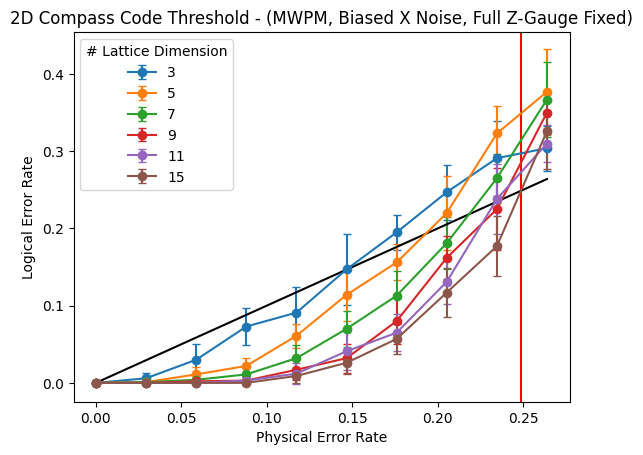

In [60]:
for dim in compass_code_logical_error_probs.keys():
    compass_code_logical_error_list = np.array(compass_code_logical_error_probs[dim])
    logical_error_list_mean = np.mean(compass_code_logical_error_list, axis=0)
    logical_error_list_std = np.std(compass_code_logical_error_list, axis=0)
    plt.errorbar(total_phys_err_rates_range, logical_error_list_mean, yerr=logical_error_list_std, label=str(dim), capsize=3, fmt='o-')

plt.xlabel('Physical Error Rate')
plt.ylabel('Logical Error Rate')
plt.axvline(0.249, color='red')
plt.title('2D Compass Code Threshold - (MWPM, Biased X Noise, Full Z-Gauge Fixed)')
plt.plot(total_phys_err_rates_range, total_phys_err_rates_range, color='black')
plt.legend(title='# Lattice Dimension')

In [324]:
# Surface Code Simulation
# Biased towards X errors

dims = [3,5,7,9,11,15]
phys_err_rates_range = np.linspace(0.0001, 0.13, 10)
num_errors = 100 
bootstrapped_runs = 10
logical_errors = {dim: np.zeros((bootstrapped_runs, len(phys_err_rates_range),)) for dim in dims}

for dim in tqdm(dims):
    for bsr in range(bootstrapped_runs):
        lat = compass_to_surface(dim, dim)
        for i, phys_rate in enumerate(phys_err_rates_range):
            rates = [phys_rate, phys_rate * 0.1, phys_rate * 0.1]
            for err in range(num_errors):
                E = random_pauli(lat.size(), rates)
                while E == 'I' * lat.size():
                    E = random_pauli(lat.size(), rates)
                error = pauli2vector(E)
                pcheckX = lat.pcheckX() 
                pcheckZ = lat.pcheckZ() 
                pcheck = np.vstack((pcheckX, pcheckZ)) 
                syndromeZ = twisted_product(pcheckX, pauli2vector(E)) # Z-error syndrome 
                syndromeX = twisted_product(pcheckZ, pauli2vector(E)) # X-error syndrome 
                Hx = pcheck_clipX(pcheckX)
                Hz = pcheck_clipZ(pcheckZ)
                decodingX = Matching.from_check_matrix(Hx)
                decodingZ = Matching.from_check_matrix(Hz)
                recoveryX = decodingX.decode(syndromeZ)
                recoveryZ = decodingZ.decode(syndromeX)
                recovery = np.concatenate((recoveryZ, recoveryX))
                corrected_error = pauli2vector(E) + recovery % 2 

                if (twisted_product(pauli2vector(lat.Lx), corrected_error) == 1) or (twisted_product(pauli2vector(lat.Lz), corrected_error) == 1):
                    logical_errors[dim][bsr][i] += 1
total_phys_err_rates_range = [np.sum([r * 0.1, r * 0.1, r]) for r in phys_err_rates_range]

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [02:28<00:00, 24.82s/it]


In [220]:
surface_code_logical_error_probs = {int(dim) : [] for dim in logical_errors.keys()}
for dim in logical_errors.keys():
    for row in logical_errors[dim]:
        surface_code_logical_error_probs[dim].append(row/num_errors)

with open('data/phys_vs_log_err_rate_biased_surface_code_mwpm_2', 'wb') as fp:
    pickle.dump(surface_code_logical_error_probs, fp)

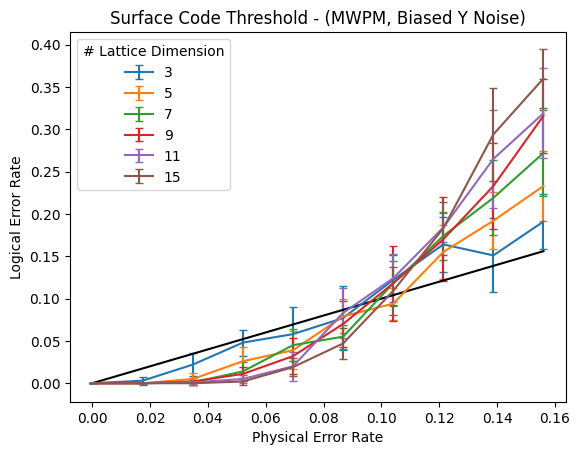

In [221]:
for dim in surface_code_logical_error_probs.keys():
    surface_code_logical_error_list = np.array(surface_code_logical_error_probs[dim])
    logical_error_list_mean = np.mean(surface_code_logical_error_list, axis=0)
    logical_error_list_std = np.std(surface_code_logical_error_list, axis=0)
    plt.errorbar(total_phys_err_rates_range, logical_error_list_mean, yerr=logical_error_list_std, label=str(dim), capsize=3)

plt.xlabel('Physical Error Rate')
plt.ylabel('Logical Error Rate')
plt.title('Surface Code Threshold - (MWPM, Biased Y Noise)')
plt.plot(total_phys_err_rates_range, total_phys_err_rates_range, color='black')
plt.legend(title='# Lattice Dimension')

In [222]:
# Compass Code Simulation
# Biased X Error
dims = [3,5,7,9,11,15]
phys_err_rates_range = np.linspace(0.0001, 0.13, 10)
num_errors = 100 
num_gauge_fixings = 10
logical_errors = {dim: np.zeros((num_gauge_fixings, len(phys_err_rates_range),)) for dim in dims}

for dim in tqdm(dims):
    for gf in range(num_gauge_fixings):
        lat = Lattice2D(dim, dim)
        coloring = choose_gauge_fixing(dim, dim, type=-1, region=None)
        lat.color_lattice(coloring)
        for i, phys_rate in enumerate(phys_err_rates_range):
            rates = [phys_rate, phys_rate * 0.1, phys_rate * 0.1]
            for err in range(num_errors):
                E = random_pauli(lat.size(), rates)
                while E == 'I' * lat.size():
                    E = random_pauli(lat.size(), rates)
                error = pauli2vector(E)
                pcheckX = lat.pcheckX() 
                pcheckZ = lat.pcheckZ() 
                pcheck = np.vstack((pcheckX, pcheckZ)) 
                syndromeZ = twisted_product(pcheckX, pauli2vector(E)) # Z-error syndrome 
                syndromeX = twisted_product(pcheckZ, pauli2vector(E)) # X-error syndrome 
                Hx = pcheck_clipX(pcheckX)
                Hz = pcheck_clipZ(pcheckZ)
                decodingX = Matching.from_check_matrix(Hx)
                decodingZ = Matching.from_check_matrix(Hz)
                recoveryX = decodingX.decode(syndromeZ)
                recoveryZ = decodingZ.decode(syndromeX)
                recovery = np.concatenate((recoveryZ, recoveryX))
                corrected_error = pauli2vector(E) + recovery % 2 

                if (twisted_product(pauli2vector(lat.Lx), corrected_error) == 1) or (twisted_product(pauli2vector(lat.Lz), corrected_error) == 1):
                    logical_errors[dim][gf][i] += 1
total_phys_err_rates_range = [np.sum([r * 0.1, r * 0.1, r]) for r in phys_err_rates_range]

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [02:30<00:00, 25.04s/it]


In [223]:
compass_code_logical_error_probs = {int(dim) : [] for dim in logical_errors.keys()}
for dim in logical_errors.keys():
    for row in logical_errors[dim]:
        compass_code_logical_error_probs[dim].append(row/num_errors)

with open('data/phys_vs_log_err_rate_biased_compass_code_mwpm_2', 'wb') as fp:
    pickle.dump(compass_code_logical_error_probs, fp)

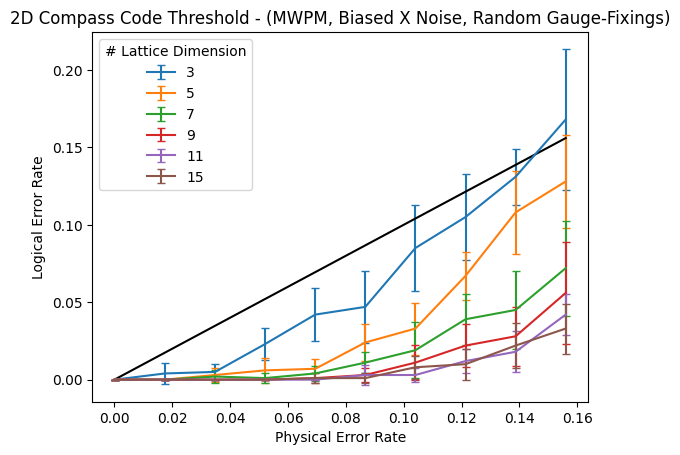

In [225]:
for dim in compass_code_logical_error_probs.keys():
    compass_code_logical_error_list = np.array(compass_code_logical_error_probs[dim])
    logical_error_list_mean = np.mean(compass_code_logical_error_list, axis=0)
    logical_error_list_std = np.std(compass_code_logical_error_list, axis=0)
    plt.errorbar(total_phys_err_rates_range, logical_error_list_mean, yerr=logical_error_list_std, label=str(dim), capsize=3)

plt.xlabel('Physical Error Rate')
plt.ylabel('Logical Error Rate')
plt.title('2D Compass Code Threshold - (MWPM, Biased X Noise, Random Gauge-Fixings)')
plt.plot(total_phys_err_rates_range, total_phys_err_rates_range, color='black')
plt.legend(title='# Lattice Dimension')

* Compass Code outperforms Surface Code under Biased X and Z Noise
* We expect the Surface Code to outperform the Compass Code under biased Y noise
    * Why? Essentially equivalent to equal bias in X and Z noise a regime where we expect better performance from Surface Code

### 2D Compass Codes vs Surface Code (Asymmetric & Unbiased Pauli Noise)

In [329]:
lat = Lattice2D(10, 10)
coloring = choose_gauge_fixing(10, 10, type=None, region='SE')
lat.color_lattice(coloring)
print(lat)

000---001---002---003---004---005---006---007---008---009
 |     |     |     |     |     |     |     |     |     |
010---011---012---013---014---015---016---017---018---019
 |     |     |     |     |     |     |     |     |     |
020---021---022---023---024---025---026---027---028---029
 |     |     |     |     |     |     |     |     |     |
030---031---032---033---034---035---036---037---038---039
 |     |     |     |     |     |     |     |     |     |
040---041---042---043---044---045---046---047---048---049
 |     |     |     |     |     |  ░  |     |  ▓  |     |
050---051---052---053---054---055---056---057---058---059
 |     |     |     |     |  ░  |     |  ▓  |  ░  |     |
060---061---062---063---064---065---066---067---068---069
 |     |     |     |     |  ▓  |  ▓  |  ░  |  ░  |     |
070---071---072---073---074---075---076---077---078---079
 |     |     |     |     |  ▓  |     |  ░  |  ▓  |     |
080---081---082---083---084---085---086---087---088---089
 |     |     |     |  

In [280]:
E = random_pauli_asym(10, 10, [0.3,0.3,0.3], dir='SE')
print_pauli_error(E, 10, 10)

_ | _ | _ | _ | _ | _ | _ | _ | _ | _
_ | _ | _ | _ | _ | _ | _ | _ | _ | _
_ | _ | _ | _ | _ | _ | _ | _ | _ | _
_ | _ | _ | _ | _ | _ | _ | _ | _ | _
_ | _ | _ | _ | _ | _ | _ | _ | _ | _
_ | _ | _ | _ | _ | Z | Z | Z | X | Z
_ | _ | _ | _ | _ | _ | Z | _ | Z | Y
_ | _ | _ | _ | _ | Y | Y | X | Z | X
_ | _ | _ | _ | _ | X | Z | _ | _ | Z
_ | _ | _ | _ | _ | Y | Y | Y | Y | Z


In [250]:
# Surface Code Simulation
# Asymmetric in South-East Direction

dims = [3,5,7,9,11,15]
phys_err_rates_range = np.linspace(0.0001, 0.3, 10)
num_errors = 100 
bootstrapped_runs = 10
logical_errors = {dim: np.zeros((bootstrapped_runs, len(phys_err_rates_range),)) for dim in dims}
all_rates = []

for dim in tqdm(dims):
    for bsr in range(bootstrapped_runs):
        lat = compass_to_surface(dim, dim)
        for i, phys_rate in enumerate(phys_err_rates_range):
            rates = [phys_rate, phys_rate, phys_rate]
            for err in range(num_errors):
                E = random_pauli_asym(lat.dimX, lat.dimZ, rates, 'SE')
                while E == 'I' * lat.size():
                    E = random_pauli(lat.size(), rates)
                error = pauli2vector(E)
                pcheckX = lat.pcheckX() 
                pcheckZ = lat.pcheckZ() 
                pcheck = np.vstack((pcheckX, pcheckZ)) 
                syndromeZ = twisted_product(pcheckX, pauli2vector(E)) # Z-error syndrome 
                syndromeX = twisted_product(pcheckZ, pauli2vector(E)) # X-error syndrome 
                Hx = pcheck_clipX(pcheckX)
                Hz = pcheck_clipZ(pcheckZ)
                decodingX = Matching.from_check_matrix(Hx)
                decodingZ = Matching.from_check_matrix(Hz)
                recoveryX = decodingX.decode(syndromeZ)
                recoveryZ = decodingZ.decode(syndromeX)
                recovery = np.concatenate((recoveryZ, recoveryX))
                corrected_error = pauli2vector(E) + recovery % 2 

                if (twisted_product(pauli2vector(lat.Lx), corrected_error) == 1) or (twisted_product(pauli2vector(lat.Lz), corrected_error) == 1):
                    logical_errors[dim][bsr][i] += 1
total_phys_err_rates_range = [np.sum([r, r, r]) for r in phys_err_rates_range]

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [02:39<00:00, 26.51s/it]


In [251]:
surface_code_logical_error_probs = {int(dim) : [] for dim in logical_errors.keys()}
for dim in logical_errors.keys():
    for row in logical_errors[dim]:
        surface_code_logical_error_probs[dim].append(row/num_errors)

with open('data/phys_vs_log_err_rate_asym_surface_code_mwpm_1', 'wb') as fp:
    pickle.dump(surface_code_logical_error_probs, fp)

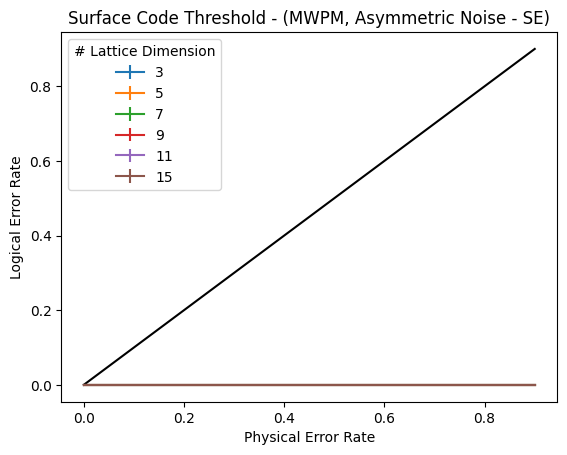

In [252]:
for dim in surface_code_logical_error_probs.keys():
    surface_code_logical_error_list = np.array(surface_code_logical_error_probs[dim])
    logical_error_list_mean = np.mean(surface_code_logical_error_list, axis=0)
    logical_error_list_std = np.std(surface_code_logical_error_list, axis=0)
    plt.errorbar(total_phys_err_rates_range, logical_error_list_mean, yerr=logical_error_list_std, label=str(dim))

plt.xlabel('Physical Error Rate')
plt.ylabel('Logical Error Rate')
plt.title('Surface Code Threshold - (MWPM, Asymmetric Noise - SE)')
plt.plot(total_phys_err_rates_range, total_phys_err_rates_range, color='black')
plt.legend(title='# Lattice Dimension')